<a href="https://colab.research.google.com/github/LeoisWTT/PHYS3151-Machine-Learning-in-Physics-2023/blob/main/SVM_Fermi_Surface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt  
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


/usr/local/lib/python3.8/dist-packages/mpl_toolkits/mplot3d/art3d.py:304: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._segments3d = np.asanyarray(segments)


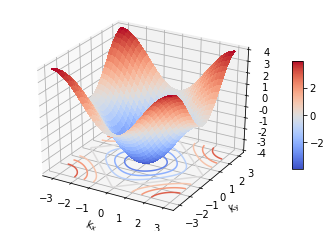

In [46]:
fig = plt.figure()
ax = fig.gca(projection='3d')
# Make data.
X = np.arange(-np.pi, np.pi, 0.1)
Y = np.arange(-np.pi, np.pi, 0.1)

X, Y = np.meshgrid(X, Y)
Z = -2*(np.cos(X)+np.cos(Y))

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)
cset = ax.contour(X, Y, Z, zdir='z', offset=-4, cmap=cm.coolwarm)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.set_xlabel('$k_x$')
ax.set_ylabel('$k_y$')
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()

# SVM

In [47]:
N=50
mu=0    #fermi energy

In [48]:
kx_list=np.pi*np.array([np.random.random() for i in range(N)]).reshape((N,1))
ky_list=np.pi*np.array([np.random.random() for i in range(N)]).reshape((N,1))

In [49]:
E=[float(-2*(np.cos(kx_list[i])+np.cos(ky_list[i]))) for i in range(N)]
#print(E)
occupancy=[E[i]<=mu for i in range(N)]
#print(occupancy)

In [50]:
def hinge(X,y,theta):                        #for maximum-margin classification
    pred = 1 - np.multiply(y,(X.dot(theta)))
    loss = np.maximum(np.zeros(pred.shape),pred)
    hinge = np.sum(loss)
    return hinge

def computeCost(X,y,theta,reg=0):
    m = float(len(y))
    theta2 = np.square(theta)
    cost = (reg/(2*m)) * np.sum(theta2) + (1/m) * hinge(X,y,theta)
    return cost

In [51]:
def check(X,y,theta):
    X_b = np.c_[np.ones((len(X),1)),X]
    
    fx = np.multiply(y,(X_b.dot(theta)))
    
    check = np.less(fx,np.ones(fx.shape))
    
    check = np.where(check==True,1,0)
    
    return check

def subgradient_descent(X,y,theta,iterations=100,reg=0):
    '''
    X    = Matrix of X
    y    = Vector of Y
    theta=Vector of thetas np.random.randn(j,1)
    alpha 
    iterations = no of iterations
    
    Returns the final theta vector and array of cost history over no of iterations
    '''
    m = float(y.shape[0])
    
    X_b = np.c_[np.ones((len(X),1)),X]
    
    cost_history = np.zeros(iterations)
    
    theta_history = np.zeros((iterations,X_b.shape[1]))
    
    for it in range(iterations):
        alpha = 1/(reg*(it+1))
        #print(X_b.shape)
        #print(X_b.dot(theta).shape)
        #print(np.multiply(y,(X_b.dot(theta))).shape)
        #print(y.shape)
        theta = theta + alpha*((np.multiply(check(X,y,theta),y)).T.dot(X_b)).T
        theta[1:] = theta[1:] - alpha*reg*theta[1:]
        theta_history[it,:] = theta.T
        cost_history[it]  = computeCost(X_b,y,theta,reg)
        
    return theta, cost_history, theta_history

In [52]:
y = np.where(occupancy,1.,-1.).reshape((N,1))
#print(y)

In [53]:
X=np.array([kx_list[:,0], ky_list[:,0]])
X=X.T
X_b = np.c_[np.ones((N,1)),X]
n=X_b.shape[1]
theta = np.random.random((n,1))

In [54]:
reg = 0.0001
n_iter = 20000
theta,cost_history,theta_history = subgradient_descent(X,y,theta,n_iter,reg)
print(theta)
print('Final Cost is :', cost_history[-1])

[[18277.62808571]
 [-4562.62738384]
 [-6591.39651773]]
Final Cost is : 398.34561551942835


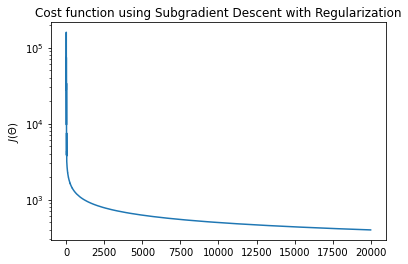

In [55]:
import matplotlib.pyplot as plt
plt.plot(cost_history)
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Subgradient Descent with Regularization")
plt.yscale('log')
plt.show()

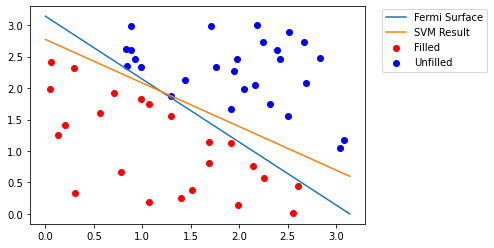

In [56]:
x_plot=np.array([0, np.pi])
plt.plot(x_plot,-x_plot+np.pi,label='Fermi Surface')
plt.scatter(kx_list[occupancy], ky_list[occupancy], c='r',label='Filled')
plt.scatter(kx_list[np.invert(occupancy)], ky_list[np.invert(occupancy)], c='b',label='Unfilled')
plt.plot(x_plot, (-theta[1]*x_plot-theta[0])/theta[2],label='SVM Result')
plt.legend(loc=(1.05,0.7))

# Logistic Regression

In [57]:
import numpy as np
from scipy.optimize import fmin_tnc


class LogisticRegressionUsingGD:

# Activation function used to map any real value between 0 and 1
    @staticmethod
    def sigmoid(x):  
        return 1 / (1 + np.exp(-x))

# Computes the weighted sum of inputs Similar to Linear Regression
    @staticmethod
    def net_input(theta, x):
        return np.dot(x, theta)

# Calculates the probability that an instance belongs to a particular class
    def probability(self, theta, x):
        return self.sigmoid(self.net_input(theta, x))

# Computes the cost function for all the training samples
    def cost_function(self, theta, x, y):
        m = x.shape[0]
        total_cost = -(1 / m) * np.sum([np.log(self.probability(theta, x[i])) if y[i]==1 else np.log(1-self.probability(theta, x[i])) for i in range(m)])
        return total_cost

# Computes the gradient of the cost function at the point theta
    def gradient(self, theta, x, y):     
        m = x.shape[0]
        return (1 / m) * np.dot(x.T, self.sigmoid(self.net_input(theta, x)) - y)

    def fit(self, x, y, theta):
        opt_weights = fmin_tnc(func=self.cost_function, x0=theta, fprime=self.gradient, args=(x, y.flatten()))
        self.w_ = opt_weights[0]
        return self

    def predict(self, x):
        theta = self.w_[:, np.newaxis]
        return self.probability(theta, x)

    def accuracy(self, x, actual_classes, probab_threshold=0.5):
        predicted_classes = (self.predict(x) >= probab_threshold).astype(int)
        predicted_classes = predicted_classes.flatten()
        accuracy = np.mean(predicted_classes == actual_classes)
        return accuracy * 100

In [58]:
y = np.where(occupancy,1.,0.).reshape((N,1))
y = np.array(y)
#print(y)
theta = np.zeros((X_b.shape[1], 1))

In [59]:
model1 = LogisticRegressionUsingGD()
model1.fit(X_b, y, theta)
accuracy = model1.accuracy(X_b, y.flatten())
parameters = model1.w_
print("The accuracy of the model is {}".format(accuracy))
print("The model parameters got by Gradient descent:")
print(parameters)

The accuracy of the model is 100.0
The model parameters got by Gradient descent:
[259.69820284 -65.11534283 -98.85407855]


<ipython-input-60-a2b709453582>:6: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(x_plot, (-theta[1]*x_plot-theta[0])/theta[2],label='SVM Result')


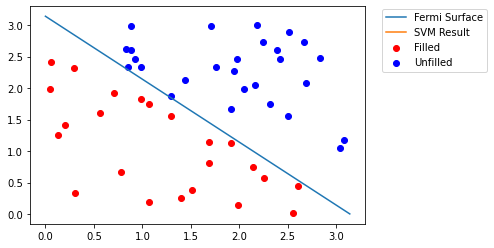

In [60]:
x_plot=np.arange(0, np.pi, 0.01)
y_plot=np.arccos(-mu/2-np.cos(x_plot))
plt.plot(x_plot,-x_plot+np.pi,label='Fermi Surface')
plt.scatter(kx_list[occupancy], ky_list[occupancy], c='r',label='Filled')
plt.scatter(kx_list[np.invert(occupancy)], ky_list[np.invert(occupancy)], c='b',label='Unfilled')
plt.plot(x_plot, (-theta[1]*x_plot-theta[0])/theta[2],label='SVM Result')
plt.legend(loc=(1.05,0.7))

# Away from Half-fill

In [89]:
N=100
mu=-1    #fermi energy

In [90]:
kx_list=np.pi*np.array([np.random.random() for i in range(N)]).reshape((N,1))
ky_list=np.pi*np.array([np.random.random() for i in range(N)]).reshape((N,1))

In [91]:
E=[float(-2*(np.cos(kx_list[i])+np.cos(ky_list[i]))) for i in range(N)]
#print(E)
occupancy=[E[i]<=mu for i in range(N)]
#print(occupancy)

# SVM

In [92]:
def hinge(X,y,theta):                        #for maximum-margin classification
    pred = 1 - np.multiply(y,(X.dot(theta)))
    loss = np.maximum(np.zeros(pred.shape),pred)
    hinge = np.sum(loss)
    return hinge

def computeCost(X,y,theta,reg=0):
    m = float(len(y))
    theta2 = np.square(theta)
    cost = (reg/(2*m)) * np.sum(theta2) + (1/m) * hinge(X,y,theta)
    return cost

In [93]:
def check(X,y,theta):
    X_b = np.c_[np.ones((len(X),1)),X]
    
    fx = np.multiply(y,(X_b.dot(theta)))
    
    check = np.less(fx,np.ones(fx.shape))
    
    check = np.where(check==True,1,0)
    
    return check

def subgradient_descent(X,y,theta,iterations=100,reg=0):
    '''
    X    = Matrix of X
    y    = Vector of Y
    theta=Vector of thetas np.random.randn(j,1)
    alpha 
    iterations = no of iterations
    
    Returns the final theta vector and array of cost history over no of iterations
    '''
    m = float(y.shape[0])
    
    X_b = np.c_[np.ones((len(X),1)),X]
    
    cost_history = np.zeros(iterations)
    
    theta_history = np.zeros((iterations,X_b.shape[1]))
    
    for it in range(iterations):
        alpha = 1/(reg*(it+1))
        #print(X_b.shape)
        #print(X_b.dot(theta).shape)
        #print(np.multiply(y,(X_b.dot(theta))).shape)
        #print(y.shape)
        theta = theta + alpha*((np.multiply(check(X,y,theta),y)).T.dot(X_b)).T
        theta[1:] = theta[1:] - alpha*reg*theta[1:]
        theta_history[it,:] = theta.T
        cost_history[it]  = computeCost(X_b,y,theta,reg)
        
    return theta, cost_history, theta_history

In [94]:
y = np.where(occupancy,1.,-1.).reshape((N,1))
#print(y)

In [95]:
X=np.array([kx_list[:,0], ky_list[:,0], kx_list[:,0]**2, ky_list[:,0]**2])
X=X.T
X_b = np.c_[np.ones((N,1)),X]
n=X_b.shape[1]
theta = np.random.random((n,1))

In [96]:
reg = 0.0001
n_iter = 20000
theta,cost_history,theta_history = subgradient_descent(X,y,theta,n_iter,reg)
print(theta)
print('Final Cost is :', cost_history[-1])

[[2006.86225782]
 [-301.69021218]
 [-212.36927335]
 [-382.53869148]
 [-358.43098378]]
Final Cost is : 2.2192112174367686


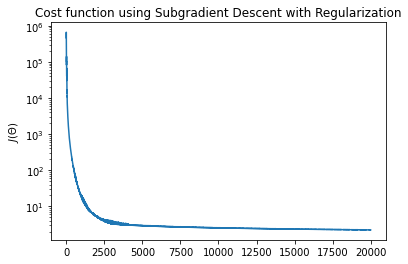

In [97]:
import matplotlib.pyplot as plt
plt.plot(cost_history)
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Subgradient Descent with Regularization")
plt.yscale('log')
plt.show()

<ipython-input-98-519de740bd62>:2: RuntimeWarning: invalid value encountered in arccos
  y_plot=np.arccos(-mu/2-np.cos(x_plot))


(0.0, 3.141592653589793)

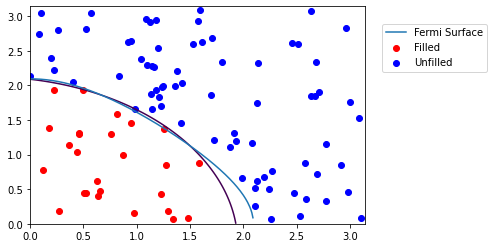

In [98]:
x_plot=np.arange(0, np.pi, 0.01)
y_plot=np.arccos(-mu/2-np.cos(x_plot))
[XX,YY]=np.meshgrid(x_plot,x_plot)
plt.plot(x_plot,y_plot,label='Fermi Surface')
plt.scatter(kx_list[occupancy], ky_list[occupancy], c='r',label='Filled')
plt.scatter(kx_list[np.invert(occupancy)], ky_list[np.invert(occupancy)], c='b',label='Unfilled')
plt.contour(XX,YY, theta[0]+theta[1]*XX+theta[2]*YY+theta[3]*XX**2+theta[4]*YY**2,[0])
plt.legend(loc=(1.05,0.7))
plt.xlim(0,np.pi)
plt.ylim(0,np.pi)

# Logistic Regression

In [99]:
import numpy as np
from scipy.optimize import fmin_tnc


class LogisticRegressionUsingGD:

# Activation function used to map any real value between 0 and 1
    @staticmethod
    def sigmoid(x):  
        return 1 / (1 + np.exp(-x))

# Computes the weighted sum of inputs Similar to Linear Regression
    @staticmethod
    def net_input(theta, x):
        return np.dot(x, theta)

# Calculates the probability that an instance belongs to a particular class
    def probability(self, theta, x):
        return self.sigmoid(self.net_input(theta, x))

# Computes the cost function for all the training samples
    def cost_function(self, theta, x, y):
        m = x.shape[0]
        total_cost = -(1 / m) * np.sum([np.log(self.probability(theta, x[i])) if y[i]==1 else np.log(1-self.probability(theta, x[i])) for i in range(m)])
        return total_cost

# Computes the gradient of the cost function at the point theta
    def gradient(self, theta, x, y):     
        m = x.shape[0]
        return (1 / m) * np.dot(x.T, self.sigmoid(self.net_input(theta, x)) - y)

    def fit(self, x, y, theta):
        opt_weights = fmin_tnc(func=self.cost_function, x0=theta, fprime=self.gradient, args=(x, y.flatten()))
        self.w_ = opt_weights[0]
        return self

    def predict(self, x):
        theta = self.w_[:, np.newaxis]
        return self.probability(theta, x)

    def accuracy(self, x, actual_classes, probab_threshold=0.5):
        predicted_classes = (self.predict(x) >= probab_threshold).astype(int)
        predicted_classes = predicted_classes.flatten()
        accuracy = np.mean(predicted_classes == actual_classes)
        return accuracy * 100

In [100]:
y = np.where(occupancy,1.,0.).reshape((N,1))
y = np.array(y)
#print(y)
theta = np.zeros((X_b.shape[1], 1))

In [101]:
model1 = LogisticRegressionUsingGD()
model1.fit(X_b, y, theta)
accuracy = model1.accuracy(X_b, y.flatten())
parameters = model1.w_
print("The accuracy of the model is {}".format(accuracy))
print("The model parameters got by Gradient descent:")
print(parameters)

The accuracy of the model is 100.0
The model parameters got by Gradient descent:
[1371.0359861  -207.42942028  -68.19297658 -302.41879975 -279.58341124]


<ipython-input-99-349e78460cf8>:10: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


(0.0, 3.141592653589793)

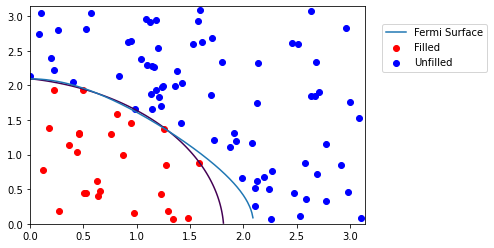

In [102]:
plt.scatter(kx_list[occupancy], ky_list[occupancy], c='r',label='Filled')
plt.scatter(kx_list[np.invert(occupancy)], ky_list[np.invert(occupancy)], c='b',label='Unfilled')
plt.plot(x_plot,y_plot,label='Fermi Surface')
plt.contour(XX,YY, parameters[0]+parameters[1]*XX+parameters[2]*YY+parameters[3]*XX**2+parameters[4]*YY**2,[0])
plt.legend(loc=(1.05,0.7))
plt.xlim(0,np.pi)
plt.ylim(0,np.pi)